# IDS 2022 Project 18 electricity

Anette Taivere, Johan Hollak, Meeri-Ly Muru

In [1]:
#Download keras, tensorflow with 

In [2]:
import sklearn
import sklearn.preprocessing
import sklearn.utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import max_error, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing

from keras.layers import Dense, Input, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.models import load_model

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

2022-12-12 11:44:22.184642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 11:44:22.443756: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-12 11:44:22.454874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 11:44:22.454904: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
# Read in the data
failinimi = 'train.csv'
train = pd.read_csv(failinimi, sep=',', header = 0)
test = pd.read_csv('test.csv', sep=',', header = 0)
ennustatav = "consumption"

In [4]:
# Replace NaN values
train=train.fillna(0) 

train[['date','timeIn24']] = train.time.str.split(expand=True)
train['timeIn24']=train.timeIn24.str.split('+' , expand=True)[0]
train['timeIn24']=train.timeIn24.str.split(':' , expand=True)[0]
train['timeIn24']=train['timeIn24'].astype(float)

test=test.fillna(0)

test[['date','timeIn24']] = test.time.str.split(expand=True)
test['timeIn24']=test.timeIn24.str.split('+' , expand=True)[0]
test['timeIn24']=test.timeIn24.str.split(':' , expand=True)[0]
test['timeIn24']=test['timeIn24'].astype(float)

In [5]:
# Normalize values
scaler_train = sklearn.preprocessing.MinMaxScaler()
train[[ 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'coco', 'el_price','timeIn24']] = scaler_train.fit_transform(train[[ 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'coco', 'el_price','timeIn24']])

scaler_y_train = sklearn.preprocessing.MinMaxScaler()
train[["consumption"]] = scaler_y_train.fit_transform(train[["consumption"]])

scaler_test = sklearn.preprocessing.MinMaxScaler()
test[[ 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'coco', 'el_price','timeIn24']] = scaler_test.fit_transform(test[[ 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'coco', 'el_price','timeIn24']])


In [6]:
# Function for creating (compiling) the model

def model(inputshape, loss, opt):
    mdl = Sequential()

    mdl.add(Dense(64, activation="tanh", input_shape=(inputshape,)))
    mdl.add(BatchNormalization())
    mdl.add(Dense(32, activation="tanh"))
    mdl.add(BatchNormalization())
    mdl.add(Dense(16, activation="selu"))
    mdl.add(BatchNormalization())
    mdl.add(Dense(8, activation="linear"))
    mdl.add(Dense(1, activation="linear"))
    
    mdl.compile(loss=loss, optimizer=opt)
    return mdl

In [7]:
# Shuffle the training data and drop unneccesary columns, split the data into test and training data

train = sklearn.utils.shuffle(train)

X_train = train.drop(columns = ['time','consumption', 'date'])
X_train = X_train[["temp","wspd" ,"dwpt", "rhum", "el_price", "timeIn24"]]
y_train = train[['consumption']]

X_test = X_train[:150]
y_test = y_train[:150]

X_train.drop(index=X_train.index[:150],inplace=True)
y_train.drop(index=y_train.index[:150],inplace=True)

y_real = train[['consumption']]

test = test[["temp","wspd" ,"dwpt", "rhum", "el_price", "timeIn24"]]

/tmp/ipykernel_99362/1751926954.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.drop(index=y_train.index[:150],inplace=True)


In [8]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)


2022-12-12 11:44:26.259454: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-12 11:44:26.259500: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-12 11:44:26.259535: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (swamp-monitor): /proc/driver/nvidia/version does not exist
2022-12-12 11:44:26.259963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


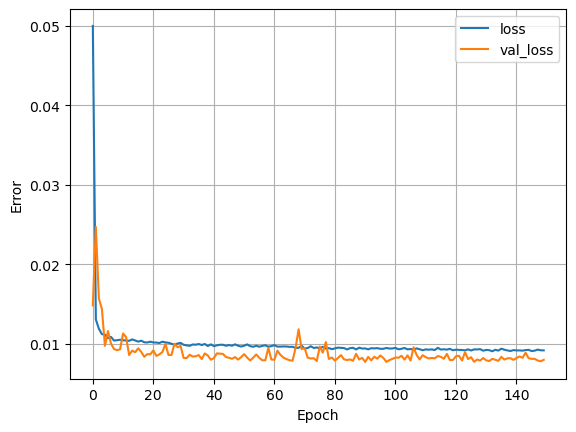

In [9]:
# Train the model
input_shape = X_train.shape[1]
mdl = model(input_shape, "mean_squared_error", "adam")
hist = mdl.fit(X_train, y_train, epochs=150, batch_size=32, verbose=False, validation_split=0.2)
plot_loss(hist)

In [10]:
# Calcultate the R-squared score

y_predicted = mdl.predict(X_test)
explained_variance_score(y_test, y_predicted)

5/5 [==============================] - 0s 3ms/step


0.14648721917269691

In [11]:
# Predict price of energy consumption on 20 first rows of train data

y_pred = mdl.predict(X_test)

print("Predicted price (normalized) - Predicted price (absolute) - Actual price")
for i in range(20):
    print(y_pred[i][0], '-', (scaler_y_train.inverse_transform([y_pred[i]])[0][0]), '-', y_test.iloc[i][0])

5/5 [==============================] - 0s 3ms/step
Predicted price (normalized) - Predicted price (absolute) - Actual price
0.11137581 - 1.1561922702789307 - 0.265196031210866
0.031651616 - 0.32857542669773104 - 0.03660533667276755
0.15412274 - 1.599948164254427 - 0.04305943550717657
0.117232606 - 1.2169916809648276 - 0.17329737019554955
0.14746428 - 1.5308266425132753 - 0.894326172815721
0.073895514 - 0.7671093309521676 - 0.042192467007032074
0.082087845 - 0.852153914898634 - 0.08062807051343801
0.11401945 - 1.1836359470486641 - 0.37115884789519316
0.10703786 - 1.1111599953323603 - 0.13611405452268566
0.032432247 - 0.33667915562167766 - 0.022252191503708697
0.06859125 - 0.7120457866936922 - 0.024756767170792792
0.07044226 - 0.7312610939145089 - 0.06579327617763221
0.12005739 - 1.2463157566636802 - 0.14391677102398612
0.10029525 - 1.0411650224104525 - 0.14998555052499757
0.04652478 - 0.4829737591780722 - 0.02331181967055197
0.08762798 - 0.9096660306155682 - 0.046912628841152104
0.07225

In [12]:
# Save model to disk and delete it from memory
mdl.save('mudel.h5')  
#del mdl

# Load model from disk with new presentable name
mdlFromDisk = load_model('mudel.h5')

In [13]:
# Predict price of energy consumption on the test data

y_pred = mdlFromDisk.predict(test)

print("Predicted price (normalized) - Predicted price (absolute)")
for i in range(20):
    print(y_pred[i][0], '-', (scaler_y_train.inverse_transform([y_pred[i]])[0][0]))

6/6 [==============================] - 0s 2ms/step
Predicted price (normalized) - Predicted price (absolute)
0.10552949 - 1.0955016059279443
0.09094569 - 0.944107216924429
0.08811699 - 0.9147424580305815
0.12548332 - 1.3026423362344504
0.12050636 - 1.2509765348583461
0.120284244 - 1.2486707413047553
0.124149546 - 1.2887964373081924
0.13315357 - 1.3822672379761936
0.13013984 - 1.3509817063361407
0.13298085 - 1.380474238306284
0.15137078 - 1.5713800534754991
0.14213397 - 1.4754927019625903
0.14161389 - 1.4700937480777503
0.13863386 - 1.4391581228524448
0.1537104 - 1.5956676115095616
0.15927528 - 1.6534366655796768
0.16043015 - 1.6654253689199687
0.13811961 - 1.433819652348757
0.15847488 - 1.6451277030855418
0.17262465 - 1.7920164669156076
